## Load packages

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Settings

In [158]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")
LABEL_PATH = os.path.join(SEAFILE_PATH, "labels")
OBJECT_CLASS = "bowl2"

OBJECT_PATH = os.path.join(IMAGE_PATH, OBJECT_CLASS)

RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")

In [3]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")

RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "tiefenbilder_gemittelt", "rgb")
DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "tiefenbilder_gemittelt", "depth")

In [384]:
def get_filtered_contours(contours):
    # Confines of the desk
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
    filtered_contours = []
    
    for contour in contours:
        x, y, w, h, = cv2.boundingRect(contour) 

        if w < 15 and h < 15:
            continue

        if x+w > xmax or y+h > ymax:
            pass

        if w*h < 500:
            pass 

        if w/h > 2:
            pass

        filtered_contours.append((x, y, w, h)) 
    return filtered_contours

In [308]:
# Combine multiple bounding boxes to one single bounding box
def get_bounding_box(contours):
    box_xmin, box_xmax, box_ymin, box_ymax = 0, 0, 0, 0

    for contour in contours:
        x, y, w, h, = contour

        if box_xmin == 0 or x < box_xmin:
            box_xmin = x

        if box_xmax == 0 or x + w > box_xmin:
            box_xmax = x + w

        if box_ymin == 0 or y < box_ymin:
            box_ymin = y

        if box_ymax == 0 or y + h < box_ymax:
            box_ymax = y + h    
            
    return box_xmin, box_xmax, box_ymin, box_ymax

In [385]:
def draw_all_contours(image, contours):
    contour_color = (0, 255, 0)
    contour_thickness = 2
    
    for contour in contours:
        box_xmin, box_xmax, box_ymin, box_ymax = 0, 0, 0, 0
        x, y, w, h, = contour
        
        if w < 10 or h < 10:
            pass
        
        if w > 500 or h > 500:
            continue
        
        if box_xmin == 0 or x < box_xmin:
            box_xmin = x

        if box_xmax == 0 or x + w > box_xmin:
            box_xmax = x + w

        if box_ymin == 0 or y < box_ymin:
            box_ymin = y

        if box_ymax == 0 or y + h < box_ymax:
            box_ymax = y + h
            
        cv2.rectangle(image, (box_xmin, box_ymin), (box_xmax, box_ymax), contour_color, contour_thickness)

In [403]:
def draw_boxes(object_name, save_to_disc=False):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
    
    
    OBJECT_PATH = os.path.join(IMAGE_PATH, object_name)
    #RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
    #DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")
    
    RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "tiefenbilder_gemittelt", "rgb")
    DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "tiefenbilder_gemittelt", "depth")
    
    detections = 0
    files = os.listdir(RGB_IMAGE_PATH)
    
    for file_name in files:
        # Read images
        rgb_img = cv2.imread(os.path.join(RGB_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')
        depth_img = cv2.imread(os.path.join(DEPTH_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')

        # Convert colours
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)     
        boxes = get_bounding_boxes(depth_img)
        result = rgb_img.copy()
        
        draw_all_contours(result, boxes)
        
        if save_to_disc:
            if not os.path.exists(os.path.join(OBJECT_PATH, "test")):
                os.mkdir(os.path.join(OBJECT_PATH, "test"))
            cv2.imwrite(os.path.join(DEPTH_IMAGE_PATH, "..", "annotation", file_name), cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

        plt.imshow(result)
        plt.show()

In [398]:
def get_bounding_boxes(depth_img):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
     
    # Remove pixels outside of table
    mask = np.zeros_like(depth_img)
    cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)
    depth_img = cv2.bitwise_and(depth_img, mask)

    BLUR_AMOUNT = 3
    CANNY_THRESH = 90
    KERNEL_SIZE = 3
    ITERATION_COUNT = 3
    
    blurred = cv2.GaussianBlur(depth_img, (BLUR_AMOUNT, BLUR_AMOUNT), 0)
    edged = cv2.Canny(blurred, CANNY_THRESH, CANNY_THRESH, CANNY_THRESH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))
    dilate = cv2.dilate(edged, kernel, iterations=ITERATION_COUNT)

    # find the contours in the dilated image
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2:])

    filtered_contours = get_filtered_contours(contours)
    
    return filtered_contours if filtered_contours else []

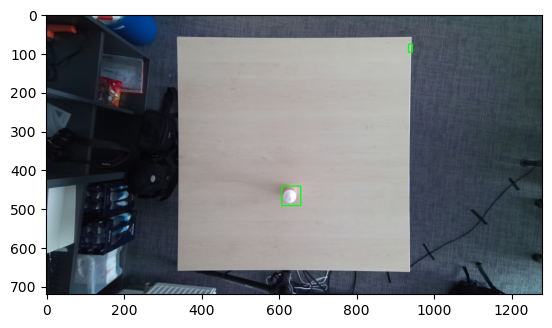

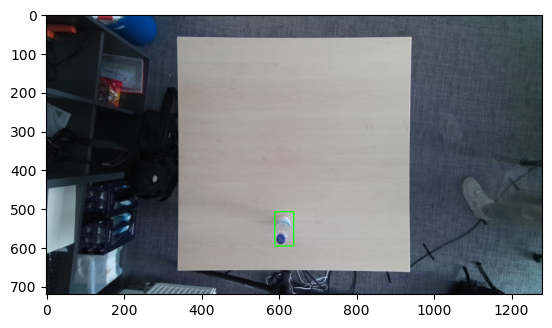

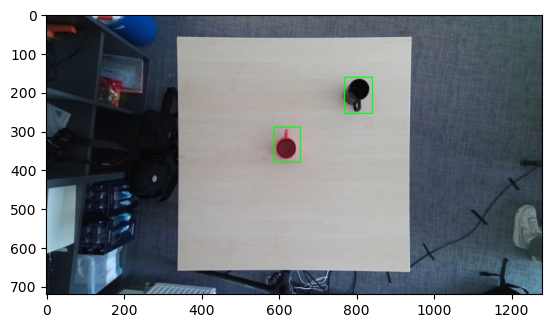

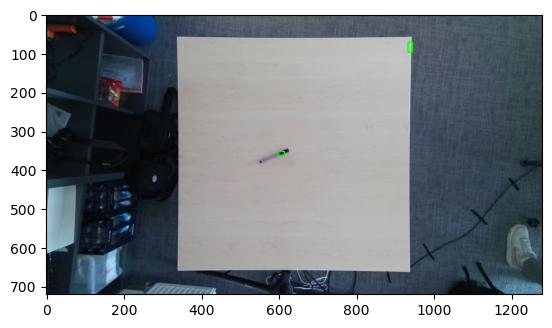

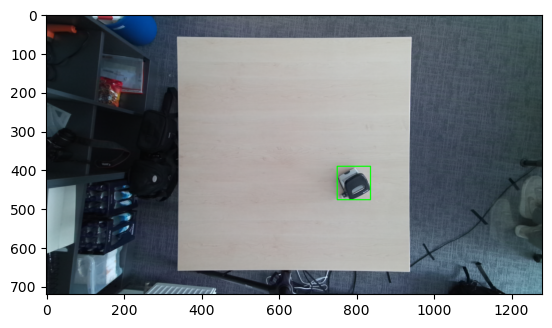

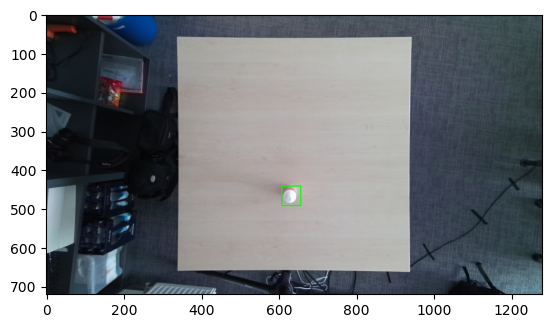

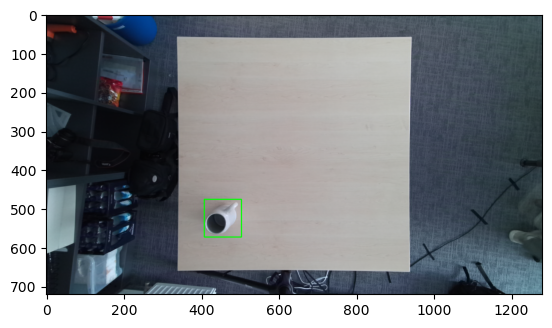

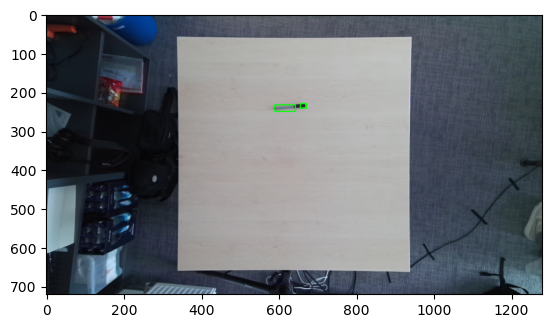

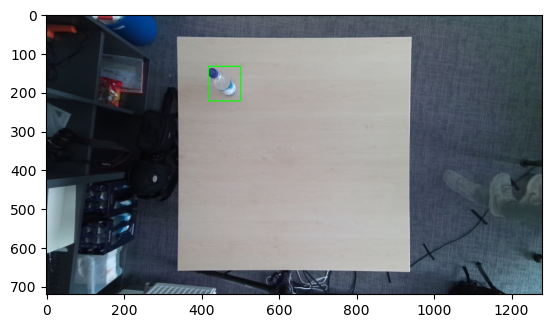

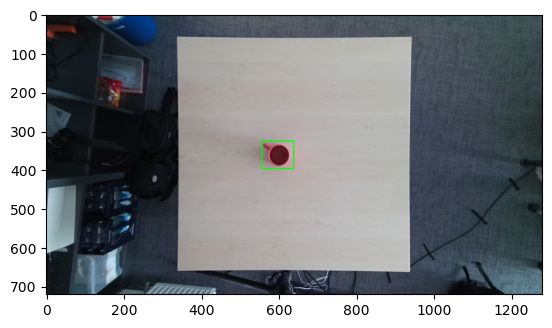

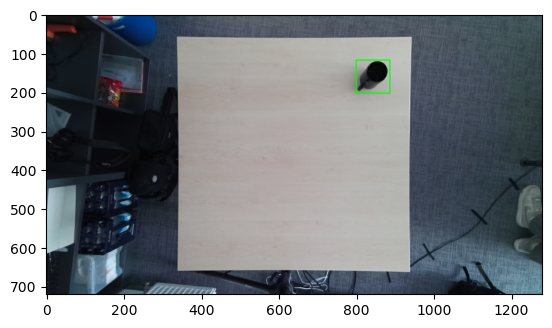

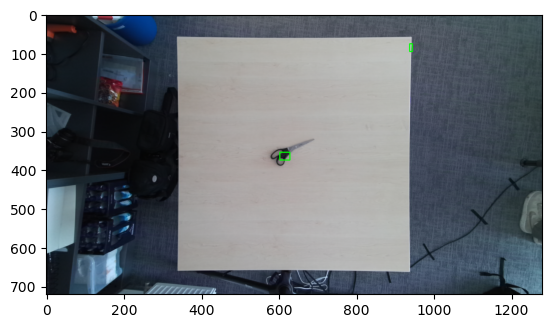

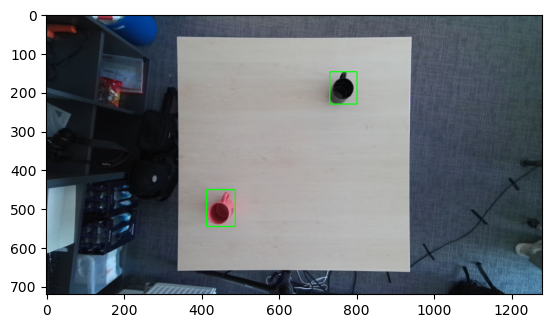

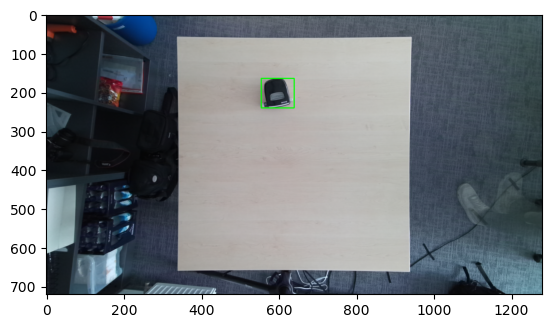

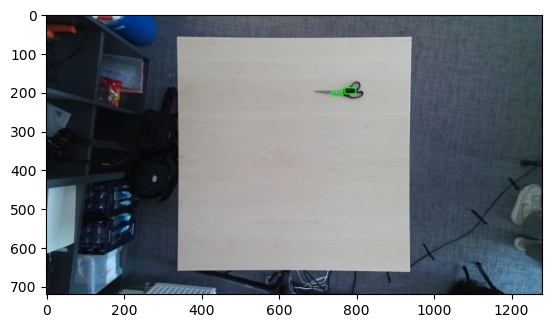

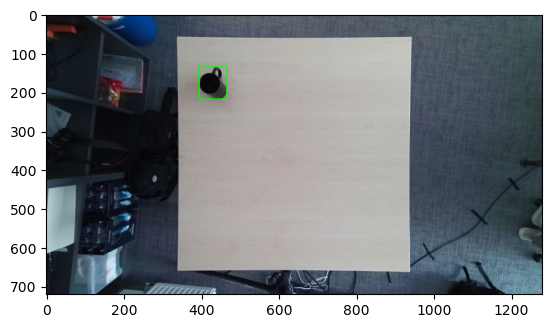

In [404]:
draw_boxes("cup")